# Business problem description:

## An Indian travel agency is interested in knowing which customers would be interested in purchasing their travel insurance package based on their existing data. To solve this business problem an exploratory and predictive analysis will be conducted. Three classification models will be built: decision tree, logistics regression and support vector machine.

##  Description of the columns in the data

[Detailed explanations of the columns can be accessed by pressing this highlighted text](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data)


## Table of contents:

### 1. Import necessary packages & load data
### 2. Data cleaning & processing
### 3. Exploratory data analysis & visualisations
**3.1 Insights from the visualisations**
### 4. Divide data into response variable Y and dataset of independent variables X
### 5. Split the data for training and testing purposes
### 6. Rebalancing the data with SMOTE
### 7. Model building
**7.1 Logistic regression**

7.1.1 Imbalanced data

7.1.2 Balanced data (SMOTE)

**7.2 SVM**

7.2.1 Imbalanced data

7.2.2 Balanced data (SMOTE)

**7.3 Decision tree models**

7.3.1 Imbalanced data

7.3.2 Balanced data (SMOTE)
### 8. Model evaluation

**8.1 Confusion matrices**

**8.2 AUC & ROC**

**8.3 The best model to use**
### 9. Recommendations for the travel agency based on the analyses





    



## 1. Import necessary packages & load data

In [1]:
#import necessary packages
import pandas as pd 
import numpy as np 
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick 
import scikitplot as skplt 
import seaborn as sn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [19]:
#load data
df = pd.read_csv('TravelInsurancePrediction.csv')

In [20]:
#get count of columns and rows of the dataset
df.shape

(1987, 10)

In [21]:
#see first 5 rows of the dataset
df.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


## 2. Data cleaning & processing

In [22]:
# Remove unnecessary index column
df = df.drop(['Unnamed: 0'], axis=1)

In [23]:
# Transform AnnualIncome from rupees to dollars
df['AnnualIncome'] = df['AnnualIncome'] / 10000

#### Encode categorical variables

The variables `Employment Type`, `GraduateOrNot`, `FrequentFlyer` and `EverTravelledAbroad` are categorical and require label encoding so that the models can use them

In [24]:
# Get dummy variables
#Add a prefix for easier identification
# Rename dummy variables
df = pd.get_dummies(df, columns=["Employment Type", "GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"], prefix=["Employment Type", "GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"], drop_first=True) 
df = df.rename(columns = {'Employment Type_Private Sector/Self Employed':'Employment_Type', 'GraduateOrNot_Yes':'Graduation_Status','FrequentFlyer_Yes':'Frequent_Flyer','EverTravelledAbroad_Yes':'Travelled_Abroad'})

In [25]:
# Check again if dataset looks as wanted
df.head(10)

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance,Employment_Type,Graduation_Status,Frequent_Flyer,Travelled_Abroad
0,31,40.0,6,1,0,0,1,0,0
1,31,125.0,7,0,0,1,1,0,0
2,34,50.0,4,1,1,1,1,0,0
3,28,70.0,3,1,0,1,1,0,0
4,28,70.0,8,1,0,1,1,1,0
5,25,115.0,4,0,0,1,0,0,0
6,31,130.0,4,0,0,0,1,0,0
7,31,135.0,3,0,1,1,1,1,1
8,28,145.0,6,1,1,1,1,1,1
9,33,80.0,3,0,0,0,1,1,0


In [26]:
#explore data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1987 non-null   int64  
 1   AnnualIncome       1987 non-null   float64
 2   FamilyMembers      1987 non-null   int64  
 3   ChronicDiseases    1987 non-null   int64  
 4   TravelInsurance    1987 non-null   int64  
 5   Employment_Type    1987 non-null   uint8  
 6   Graduation_Status  1987 non-null   uint8  
 7   Frequent_Flyer     1987 non-null   uint8  
 8   Travelled_Abroad   1987 non-null   uint8  
dtypes: float64(1), int64(4), uint8(4)
memory usage: 85.5 KB


## 3. Exploratory data analysis & visualisations

In [27]:
#summarize basic statistics for all the numerical variables
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1987.0,29.650226,2.913308,25.0,28.0,29.0,32.0,35.0
AnnualIncome,1987.0,93.276296,37.685568,30.0,60.0,90.0,125.0,180.0
FamilyMembers,1987.0,4.752894,1.609650,2.0,4.0,5.0,6.0,9.0
ChronicDiseases,1987.0,0.277806,0.448030,0.0,0.0,0.0,1.0,1.0
TravelInsurance,1987.0,0.357323,0.479332,0.0,0.0,0.0,1.0,1.0
Employment_Type,1987.0,0.713135,0.452412,0.0,0.0,1.0,1.0,1.0
Graduation_Status,1987.0,0.851535,0.355650,0.0,1.0,1.0,1.0,1.0
Frequent_Flyer,1987.0,0.209864,0.407314,0.0,0.0,0.0,0.0,1.0
Travelled_Abroad,1987.0,0.191243,0.393379,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Correlation between variables')

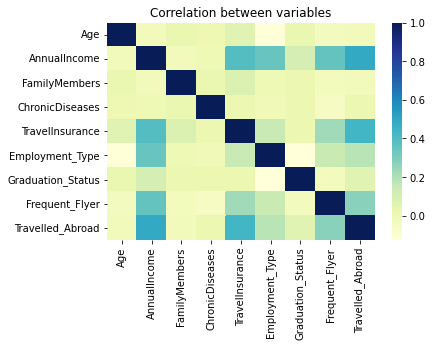

In [28]:
# Correlations between variables
sn.heatmap(df.corr(), cmap = "YlGnBu").set_title('Correlation between variables')

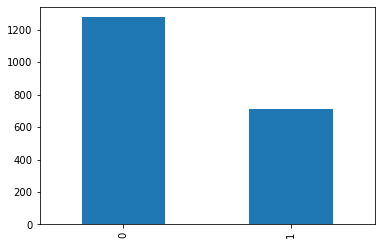

In [29]:
#Visualize the target variable(TravelInsurance) 
ax = df['TravelInsurance'].value_counts().plot(kind='bar')

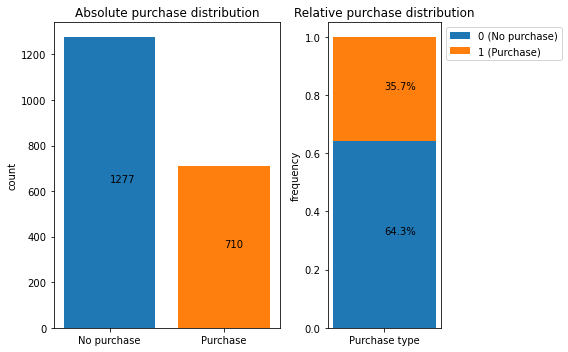

In [30]:
# plot number of purchases of travel insurance
keys, counts = np.unique(df.TravelInsurance, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1]) 

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No purchase', 'Purchase'], counts, color=['#1f77b4','#ff7f0e'])
ax0 = plt.title('Absolute purchase distribution') 
ax0 = plt.ylabel('count')
ax0 = plt.text(keys[0], counts[0]/2, counts[0]) #add text box with count of cases of not purchasing an insurance
ax0 = plt.text(keys[1], counts[1]/2, counts[1]) #add text box with count of cases of purchasing an insurance

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Purchase type'], [counts_norm[0]], label='0 (No purchase)')
ax1 = plt.bar(['Purchase type'], [counts_norm[1]], bottom=counts_norm[0], label='1 (Purchase)')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative purchase distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Purchase type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Purchase type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

### 3.1 Insights from the visualisations

-Only roughly **36%** of the customers purchased the travel insurance package previously

-Data is also **highly inbalanced** because of this

## 4. Divide data into response variable Y and dataset of independent variables X

In [33]:
#Divide data into target and response variables
X, y = df[['Age', 'Employment_Type', 'Graduation_Status', 'AnnualIncome','FamilyMembers','ChronicDiseases','Frequent_Flyer','Travelled_Abroad']], df['TravelInsurance'] #define feature matrix X and labels y

## 5. Split the data for training and testing purposes

In [34]:
#split the data for training and testing purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234) #split data 70:30

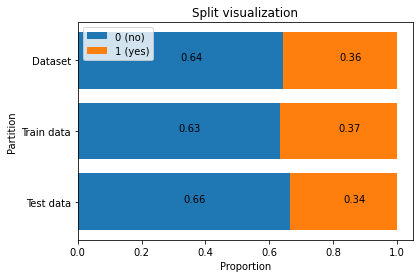

In [35]:
#visualize the split
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test data','Train data','Dataset'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Test data','Train data','Dataset'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test data', 'Train data','Dataset'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## 6. Rebalancing the data with SMOTE

<span style="color:red">As stated earlier our data is highly inbalanced which is not good, since it is biased. Therefore, our data has to be rebalanced due to this issue!</span>

In [36]:
#rebalancing the data using smote
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

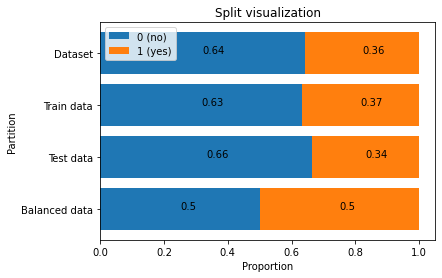

In [37]:
#Visualize the rebalancing
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['Balanced data','Test data','Train data','Dataset'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Balanced data','Test data','Train data','Dataset'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Balanced data', 'Test data', 'Train data','Dataset'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## 7. Model building


### 7.1 Logistic regression

In [ ]:
# To get an idea about relationships between variables we print the logistic regression summary
lr_summary = sm.Logit(y, sm.add_constant(X)).fit()
print(lr_summary.summary())

#### 7.1.1 Imbalanced data


/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


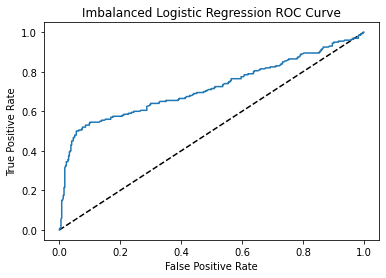

AUC:  0.72
Accuracy of the model:  78.39


In [43]:
# Imbalanced model
lr_imb = LogisticRegression(random_state=1234, max_iter=20).fit(X_train, y_train)
y_pred_lr_imb = lr_imb.predict(X_test)
y_predProba_lr_imb = lr_imb.predict_proba(X_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predProba_lr_imb[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Imbalanced Logistic Regression ROC Curve')
plt.show()

# AUC
print("AUC: ", roc_auc_score(y_test, y_predProba_lr_imb[:,1]).round(2))
print ("Accuracy of the model: ", (accuracy_score(y_test, y_pred_lr_imb)*100).round(2))

<span style="color:red">Previously imbalanced logistic regression model was only able to make negative classifications and ROC curve only ~0.25. Scaling AnnualIncome by dividing it by 10 000 fixed the problem with the model. The model is now able to classify positives and ROC curve looks sensible</span>

#### 7.1.2 Balanced data (SMOTE)

/Users/mj/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


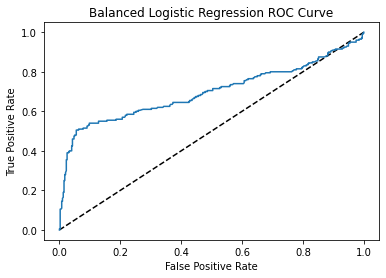

AUC:  0.7
Accuracy of the model:  71.19


In [42]:
# Balanced model
lr_bal = LogisticRegression(random_state=1234, max_iter=20).fit(X_sm, y_sm)
y_pred_lr_bal = lr_bal.predict(X_test)
y_predProba_lr_bal = lr_bal.predict_proba(X_test)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predProba_lr_bal[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balanced Logistic Regression ROC Curve')
plt.show()

# AUC
print("AUC: ", (roc_auc_score(y_test, y_predProba_lr_bal[:,1])).round(2))
print("Accuracy of the model: ", (accuracy_score(y_test, y_pred_lr_bal)*100).round(2))

### 7.2 SVM


#### 7.2.1 Imbalanced data

In [44]:
#initialize the model and fit it
svm_imb = SVC(probability=True).fit(X_train, y_train)

In [45]:
#make predictions with the model
#print its accuracy
y_pred_svm_imb = svm_imb.predict(X_test)
y_predProba_svm_imb = svm_imb.predict_proba(X_test)
print ("Accuracy of the model is: ", (accuracy_score(y_test, y_pred_svm_imb)*100).round(2))

Accuracy of the model is:  78.22


#### 7.2.2 balanced data (SMOTE)

In [46]:
#initialize the model and fit it
svm_bal = SVC(probability=True).fit(X_sm, y_sm)

In [47]:
#make predictions with the model
#print its accuracy
y_pred_svm_bal = svm_bal.predict(X_test)
y_predProba_svm_bal = svm_bal.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_svm_bal)*100).round(2))

Accuracy is:  75.88


## 7.3 Decision tree models

#### 7.3.1 Unbalanced data

In [48]:
#initialize the model and fit it
tree_imb = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3).fit(X_train, y_train)

tree_imb = tree_imb.fit(X_train, y_train)

In [49]:
#make predictions with the model
y_pred_tree_imb = tree_imb.predict(X_test)
y_predProba_tree_imb = tree_imb.predict_proba(X_test)

In [52]:
#print the accuracy of the model
print ("Accuracy of the model: ", (accuracy_score(y_test, y_pred_tree_imb)*100).round(2))

Accuracy of the model:  83.92


<span style="color:red">The classifier correctly identifies customers who decided to buy a travel insurance with almost 84% of the observations. This can be considered a good score</span>

In [53]:
#assess important features
importances = tree_imb.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

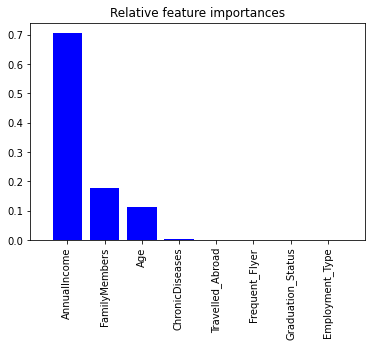

In [54]:
#plot important features
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

<span style="color:red">According to the unbalanced Decision Tree model, the significant features are annual income, family members and age. Chronic diseases are not seen as a major factor among customers!</span>

#### 7.3.2 Balanced data (SMOTE)

In [56]:
#deploy the model
#make predictions with the model
#print its accuracy
tree_bal = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3).fit(X_sm, y_sm)


y_pred_tree_bal = tree_bal.predict(X_test) 
y_predProba_tree_bal = tree_bal.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_tree_bal)*100).round(2))

Accuracy is:  83.92


## 8. Model evaluation


### 8.1 Confusion matrices

In [57]:
#create and plot confusion matrices
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

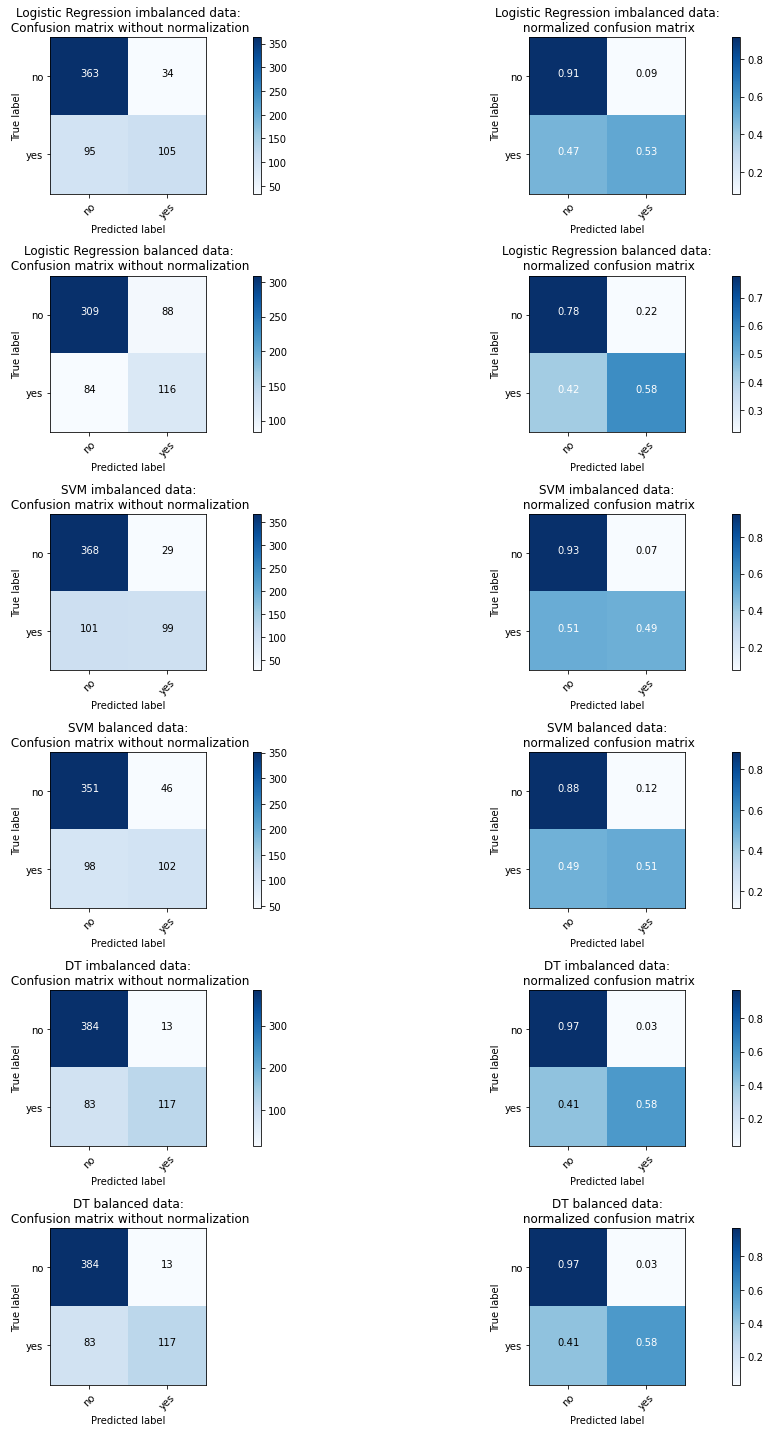

In [58]:
# Compute confusion matrix
class_names = ['no', 'yes']
cnf_matrix_lr_imb = confusion_matrix(y_test, y_pred_lr_imb)
cnf_matrix_lr_bal = confusion_matrix(y_test, y_pred_lr_bal)
cnf_matrix_svm = confusion_matrix(y_test, y_pred_svm_bal)
cnf_matrix_svm_imb = confusion_matrix(y_test, y_pred_svm_imb)
cnf_matrix_dt_bal = confusion_matrix(y_test, y_pred_tree_bal)
cnf_matrix_dt_imb = confusion_matrix(y_test, y_pred_tree_imb)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 20))

#Plot Logistic Regression (imbalanced) confusion matrix
plt.subplot(6,2,1) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names,
                      title='Logistic Regression imbalanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (imbalanced) normalized confusion matrix
plt.subplot(6,2,2) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names, normalize=True,
                      title='Logistic Regression imbalanced data:\n normalized confusion matrix')


#Plot Logistic Regression (balanced) confusion matrix
plt.subplot(6,2,3) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names,
                      title='Logistic Regression balanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (balanced) normalized onfusion matrix
plt.subplot(6,2,4) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names, normalize=True,
                      title='Logistic Regression balanced data:\n normalized confusion matrix')

#Plot SVM imbalanced confusion matrix
plt.subplot(6,2,5) 
plot_confusion_matrix(cnf_matrix_svm_imb, classes=class_names,
                      title='SVM imbalanced data:\n Confusion matrix without normalization')

#Plot SVM imbalanced normalized confusion matrix
plt.subplot(6,2,6) 
plot_confusion_matrix(cnf_matrix_svm_imb, classes=class_names, normalize=True,
                      title='SVM imbalanced data:\n normalized confusion matrix')

#Plot SVM balanced confusion matrix
plt.subplot(6,2,7) 
plot_confusion_matrix(cnf_matrix_svm, classes=class_names,
                      title='SVM balanced data:\n Confusion matrix without normalization')

#Plot SVM balanced normalized confusion matrix
plt.subplot(6,2,8) 
plot_confusion_matrix(cnf_matrix_svm, classes=class_names, normalize=True,
                      title='SVM balanced data:\n normalized confusion matrix')

#Plot Decision Tree imbalanced confusion matrix
plt.subplot(6,2,9)
plot_confusion_matrix(cnf_matrix_dt_imb, classes=class_names,
                      title='DT imbalanced data:\n Confusion matrix without normalization')

#Plot Decision Tree imbalanced normalized confusion matrix
plt.subplot(6,2,10)
plot_confusion_matrix(cnf_matrix_dt_imb, classes=class_names, normalize=True,
                      title='DT imbalanced data:\n normalized confusion matrix')

#Plot Decision Tree balanced confusion matrix
plt.subplot(6,2,11)
plot_confusion_matrix(cnf_matrix_dt_bal, classes=class_names,
                      title='DT balanced data:\n Confusion matrix without normalization')

#Plot Decision Tree balanced normalized confusion matrix
plt.subplot(6,2,12)
plot_confusion_matrix(cnf_matrix_dt_bal, classes=class_names, normalize=True,
                      title='DT balanced data:\n normalized confusion matrix')


plt.show()

### 8.2 AUC & ROC

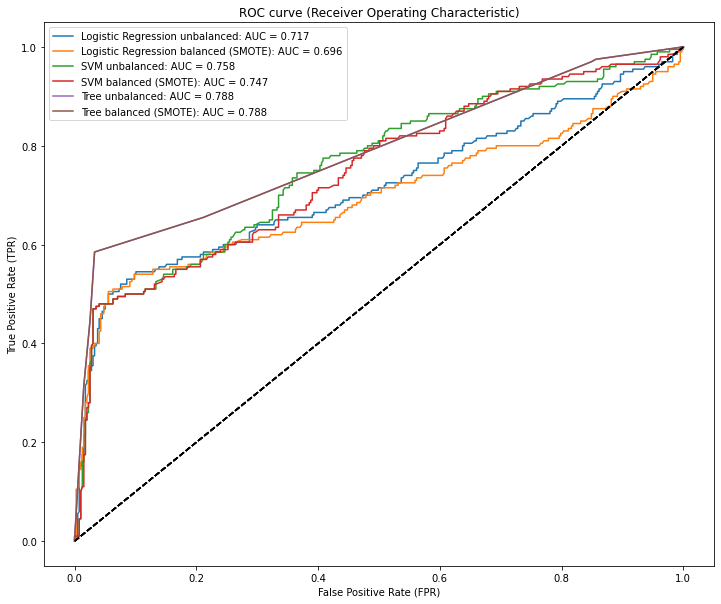

In [60]:
#plot ROC curves for all the 6 models
plt.figure(figsize=(12,10))


for test, pred, name in zip([y_test, y_test, y_test, y_test, y_test, y_test], [y_predProba_lr_imb[:,1], y_predProba_lr_bal[:,1], y_predProba_svm_imb[:,1], y_predProba_svm_bal[:,1], y_predProba_tree_imb[:,1], y_predProba_tree_bal[:,1]], ['Logistic Regression unbalanced','Logistic Regression balanced (SMOTE)', 'SVM unbalanced', 'SVM balanced (SMOTE)', 'Tree unbalanced', 'Tree balanced (SMOTE)']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')


plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')


plt.show()

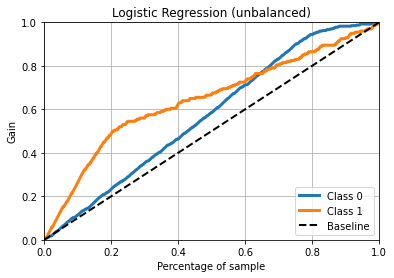

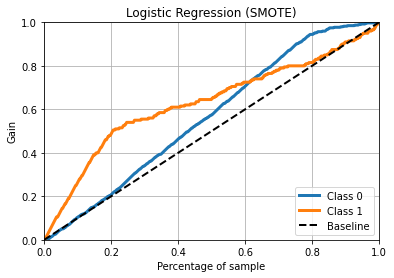

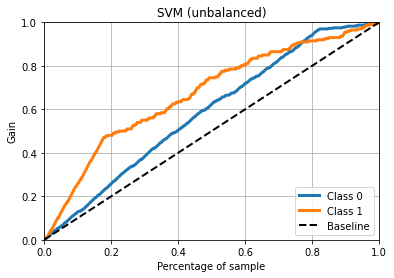

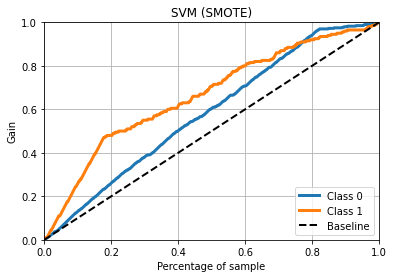

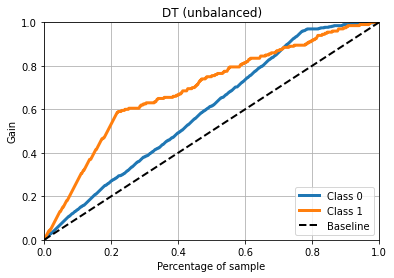

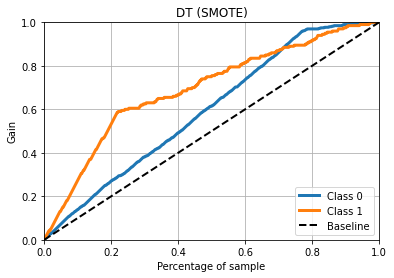

In [59]:
#plot AUC curves for all the 6 models
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_lr_imb, title='Logistic Regression (unbalanced)')
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_lr_bal, title='Logistic Regression (SMOTE)')
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_svm_imb, title='SVM (unbalanced)');
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_svm_bal, title='SVM (SMOTE)');
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_tree_imb, title='DT (unbalanced)');
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_tree_bal, title='DT (SMOTE)');

### 8.3 The best model to use

#### In this instance, the DT models seem to be the two that work the best in this situation, and they are both equally effective. The balanced model is much preferable, though, as the unbalanced one has a tendency to be more biased.

## 9. Recommendations for the travel agency based on the analyses

### Based on the carried out analyses, the company should focus on targeting high-earning individuals, couples, and families with more than six people in their early 30s.

### However, it is recommendable for the company to further investigate why most customers did not buy the package in the past. For example, carry out surveys and interviews. Additionally, the agency could also explore the possibility of developing packages that are more catered to different customer groups.